## Train Segmentation or Keypoint YOLOv8 model

Notes:
- Shear, perspective, and rotation augmentations add error to bbox w/ keypoint dataset
- Mosaic and extreme scale might hide clues about usual pose of board games (pointing to center)


In [1]:
from ultralytics import YOLO
import cv2 
import matplotlib.pyplot as plt
 
# Load the model.
model = YOLO('yolov8n-seg.pt')

# Training.
results = model.train(
   data='../project-4-at-2023-09-02-19-51-b3ad348e/data.yaml',
   imgsz=640,
   epochs=120,
   batch=8,
   name='yolov8n_azul',
   single_cls=True,
   pretrained=False,
   translate=0.3,
   degrees=10,
   scale=0.2,
   perspective=0.0005,
   shear=5,
   fliplr=0.0,
   flipud=0.0,
   mixup=0.0,
   mosaic=0.0,
   copy_paste=0.1,
)

New https://pypi.org/project/ultralytics/8.0.169 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.109 🚀 Python-3.8.10 torch-1.13.0+cu117 CPU
WARNING ⚠️ Upgrade to torch>=2.0.0 for deterministic training.
yolo/engine/trainer: task=segment, mode=train, model=yolov8n-seg.pt, data=../project-4-at-2023-09-02-19-51-b3ad348e/data.yaml, epochs=120, patience=50, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=yolov8n_azul, exist_ok=False, pretrained=False, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=True, rect=False, cos_lr=False, close_mosaic=0, resume=False, amp=True, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, line_width=None, visualize=False, 

## Convert segmentation (polygon) dataset into keypoints
Assumptions:
- Keypoints are corners of board
- There are no occluded boards on dataset
- All boards are within image

In [63]:
import pandas as pd 
from glob import glob 
import numpy as np 
import matplotlib.pyplot as plt 
from ultralytics import YOLO

labelDir = '/home/garamizo/project-4-at-2023-09-02-19-51-b3ad348e_pose/valid/labels/*.txt'

for file in glob(labelDir):

    df = pd.read_csv(file, sep=' ', header=None)
    dfOut = pd.DataFrame(columns=['cls', 'x', 'y', 'width', 'height'] +
                        [f"p{a}{i+1}" for i in range(4) for a in ['x', 'y']])

    for i, row in df.iterrows():
        xy = np.reshape(row.to_numpy()[1:], [-1, 2])
        x1, y1, x2, y2 = np.nanmin(xy[:,0]), np.nanmin(xy[:,1]), np.nanmax(xy[:,0]), np.nanmax(xy[:,1])

        dist2 = np.sum((xy - 0.5)**2, axis=1)
        idxTop = np.argsort(dist2)[:2]
        idxBot = np.argsort(dist2)[2:]

        if signed_area(xy[idxTop[0]] - 0.5, xy[idxTop[1]] - 0.5) < 0:
            idx0, idx1 = idxTop[0], idxTop[1]
        else:
            idx0, idx1 = idxTop[1], idxTop[0]

        ptMea = (xy[idx0] + xy[idx1] + xy[idxBot[0]]) / 3
        dist0i = np.sum((xy[idx0] - ptMea)**2)
        dist1i = np.sum((xy[idx1] - ptMea)**2)
        if dist0i > dist1i:
            idx2, idx3 = idxBot[0], idxBot[1]
        else:
            idx2, idx3 = idxBot[1], idxBot[0]

        xy = xy[[idx0, idx1, idx2, idx3]]
        x, y, wid, hei = (x1 + x2)/2, (y1 + y2)/2, x2 - x1, y2 - y1
        dfOut.loc[i, :] = [0, x, y, wid, hei, *xy.reshape(-1).tolist()]

    dfOut.to_csv(file, sep=' ', header=None, index=None)

## Evaluate board tracking

Given an image, segment and rectify each board

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


0: 480x640 3 boards, 138.8ms
Speed: 5.2ms preprocess, 138.8ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)


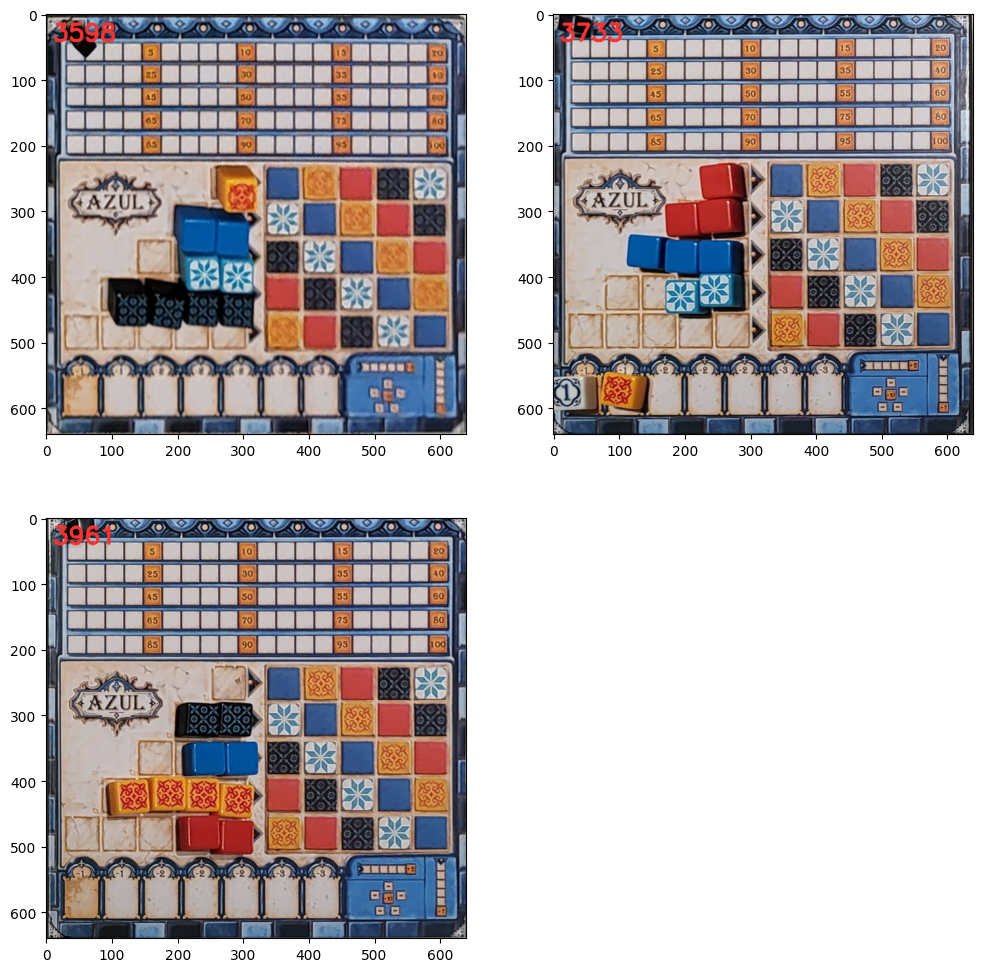

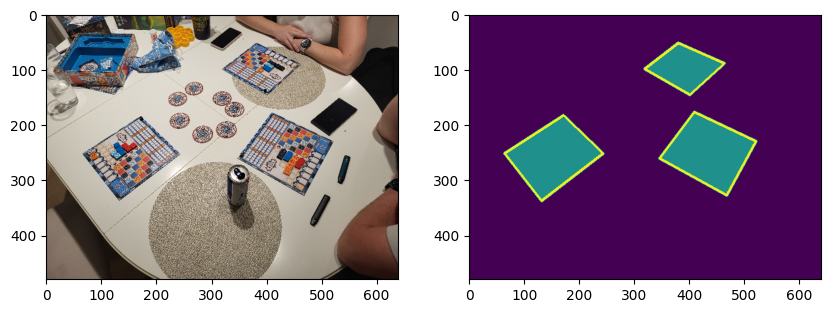

In [93]:
%load_ext autoreload 
%autoreload 2
import azul.vision as vision 
import cv2 
import numpy as np
import matplotlib.pyplot as plt 
from warnings import warn

# img = cv2.imread('../Pictures/azul/20230831_184413.jpg')  # easy
img = cv2.imread('../Pictures/azul/raw/20230831_210022.jpg')  # feasible
# img = cv2.imread('../Pictures/azul/raw/20230831_184420.jpg')  # hard
# img = cv2.imread('../Pictures/azul/20230831_214908.jpg')  # vertical
# img = cv2.imread('/home/garamizo/Pictures/azul/raw/20230831_213611.jpg')

masks = vision.segment(img)
maskMerge = np.uint8(np.sum(np.array(masks), axis=0))

h1, w1 = maskMerge.shape
hf, wf, _ = img.shape

BRD, FSZ = 50, 800
BRD2, FSZ2 = 0, 640
MIN_MATCH_VAL = 1500
sz = FSZ2 / 640
BORDER_COLOR = (81, 56, 40)

dst = np.float32([[BRD, BRD], [FSZ-BRD, BRD], [FSZ-BRD, FSZ-BRD], [BRD, FSZ-BRD]])
dst2 = np.float32([[BRD2, BRD2], [FSZ2-BRD2, BRD2], [FSZ2-BRD2, FSZ2-BRD2], [BRD2, FSZ2-BRD2]])

plt.figure(figsize=(12,12))
imgBoard = []
for i, data in enumerate(masks):

    mask = np.uint8(data)
    src = vision.corners_from_mask(mask)
    matrix = cv2.getPerspectiveTransform(
        np.float32(src * [wf/w1, hf/h1]), dst)
    frame1 = cv2.warpPerspective(img, matrix, (FSZ, FSZ), borderMode=cv2.BORDER_REPLICATE)

    cv2.polylines(maskMerge, [np.int32(src)],
                    True, color=2, thickness=int(np.ceil(3*sz)))

    src2, imgs = vision.corner_from_closeup(frame1)
    if src2 is None:
        warn('Missing edge from corner_from_closeup')
        continue
    matrix2 = cv2.getPerspectiveTransform(np.float32(src2), dst2)
    frame2 = cv2.warpPerspective(img, matrix2 @ matrix, (FSZ2, FSZ2), borderValue=BORDER_COLOR)

    frame, valMatch = vision.orient_board(frame2, border=FSZ2//50)
    if valMatch < MIN_MATCH_VAL:
        warn('Bad match for orient_board')
        # continue

    cv2.putText(frame, f"{int(valMatch)}", (10, 40),
                cv2.FONT_HERSHEY_SIMPLEX, 1.2, (50, 50, 255), int(3))
    imgBoard.append(frame)

    plt.subplot(2,2,i+1), plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB));

plt.figure(figsize=(10,5))
plt.subplot(121), plt.imshow(cv2.cvtColor(cv2.resize(img, [640, 480]), cv2.COLOR_BGR2RGB));
plt.subplot(122), plt.imshow(maskMerge);

## Generate board dataset

In [131]:
from glob import glob 
import cv2 
import azul.vision as vision 
import numpy as np

imgDir = '/home/garamizo/Pictures/azul/raw/*.jpg'
outDir = '/home/garamizo/Pictures/azul/boards/'

for file in glob(imgDir):

    img = cv2.imread(file)
    if img is None:
        continue 

    imgBoards, maskMerge = vision.get_boards(img, plot=True)
    h, w, c = imgBoards[0].shape
    numBoards = len(imgBoards)

    imgBoards = imgBoards + [np.zeros([h,w,c], np.uint8)] * (4 - numBoards)
    tiles = np.reshape(imgBoards, [2, 2, h, w, c])
    tiles = tiles.swapaxes(1, 2).reshape(h*2, w*2, c)

    h0, w0, c0 = img.shape 
    hm, wm = maskMerge.shape
    maskMerge = np.uint8(maskMerge * (255 / maskMerge.max()))
    frame = np.vstack([cv2.resize(img, [int(w0 * h/h0), h]), 
                       cv2.cvtColor(cv2.resize(maskMerge, [int(w0 * h/h0), h]), cv2.COLOR_GRAY2BGR)])
    frame = np.hstack([frame, tiles])

    cv2.imwrite(outDir + file.split('/')[-1], frame)


0: 480x640 3 boards, 108.3ms
Speed: 5.2ms preprocess, 108.3ms inference, 3.7ms postprocess per image at shape (1, 3, 640, 640)

0: 480x640 4 boards, 122.8ms
Speed: 6.0ms preprocess, 122.8ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x480 3 boards, 105.5ms
Speed: 2.6ms preprocess, 105.5ms inference, 4.2ms postprocess per image at shape (1, 3, 640, 640)

0: 480x640 3 boards, 113.8ms
Speed: 2.4ms preprocess, 113.8ms inference, 31.2ms postprocess per image at shape (1, 3, 640, 640)

0: 480x640 3 boards, 77.4ms
Speed: 3.7ms preprocess, 77.4ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 480x640 3 boards, 81.3ms
Speed: 5.5ms preprocess, 81.3ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

0: 480x640 3 boards, 102.7ms
Speed: 2.8ms preprocess, 102.7ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

0: 480x640 4 boards, 103.4ms
Speed: 4.3ms preprocess, 103.4ms inference, 4.0ms postprocess per image at sh

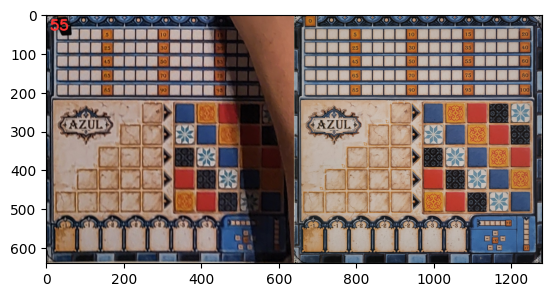

In [127]:
tmp = np.hstack([imgBoards[0], vision._template0])
# plt.imshow(cv2.cvtColor(imgBoards[0], cv2.COLOR_BGR2RGB));
plt.imshow(cv2.cvtColor(tmp, cv2.COLOR_BGR2RGB));

## Get board data from board frames
1. Score
2. Lines
3. Floor
4. Grid

Method:
- a. Background subtraction + blur
- b. Image patch classification
- c. Color segmentation (no need since position is known)

TODO:
- Get patches from frame
- Create patch dataset
- Label each patch

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


0: 480x640 4 boards, 107.1ms
Speed: 4.4ms preprocess, 107.1ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)


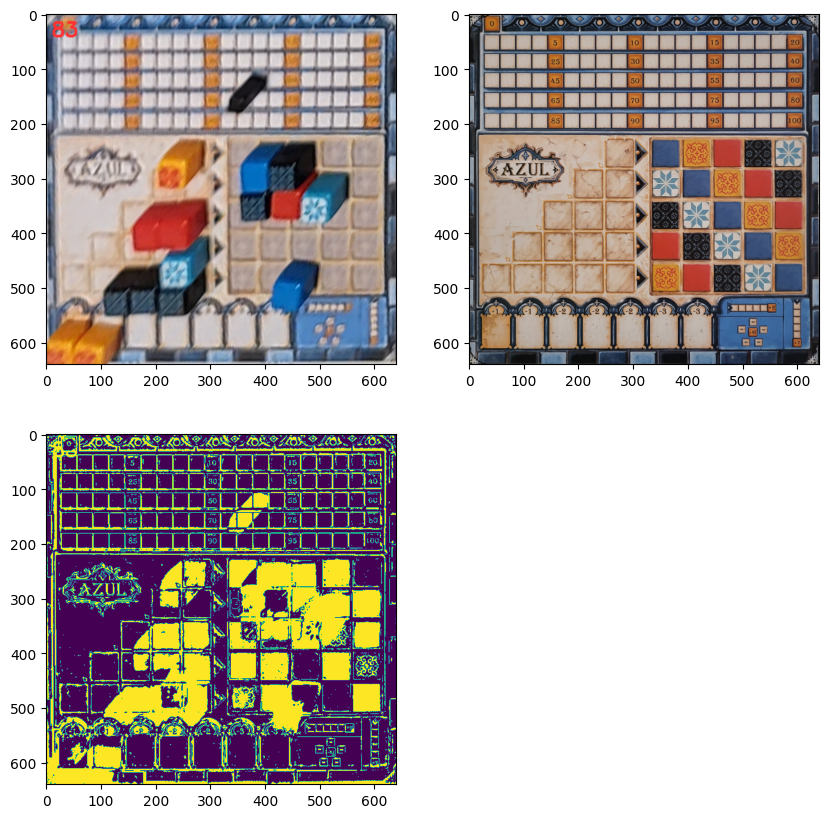

In [132]:
%load_ext autoreload 
%autoreload 2
from glob import glob 
import cv2 
import azul.vision as vision 
import numpy as np
import matplotlib.pyplot as plt

# img = cv2.imread('../Pictures/azul/raw/20230831_210022.jpg')
img = cv2.imread('../Pictures/azul/raw/20230831_184420.jpg')  # hard

imgBoards, maskMerge = vision.get_boards(img, plot=True)
h, w, c = imgBoards[0].shape
ksz = 5

template = cv2.resize(vision._template, [w, h])

# rectScore = np.round(np.array(vision.RECT_SCORE) * h).astype(np.int32)
# sizeMarker = np.round(np.array(vision.SIZE_MARKER) * h).astype(np.int32)

frame = imgBoards[3].copy()
diff = np.sum(np.abs(frame.astype(float) - template), axis=2)
# diff = np.abs(cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)[:,:,0].astype(float) - 
#               cv2.cvtColor(template, cv2.COLOR_BGR2HSV)[:,:,0])
diff = diff > diff.std() * 1.5

plt.figure(figsize=(10,10))
plt.subplot(221), plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB));
plt.subplot(222), plt.imshow(cv2.cvtColor(template, cv2.COLOR_BGR2RGB));
plt.subplot(223), plt.imshow(diff);

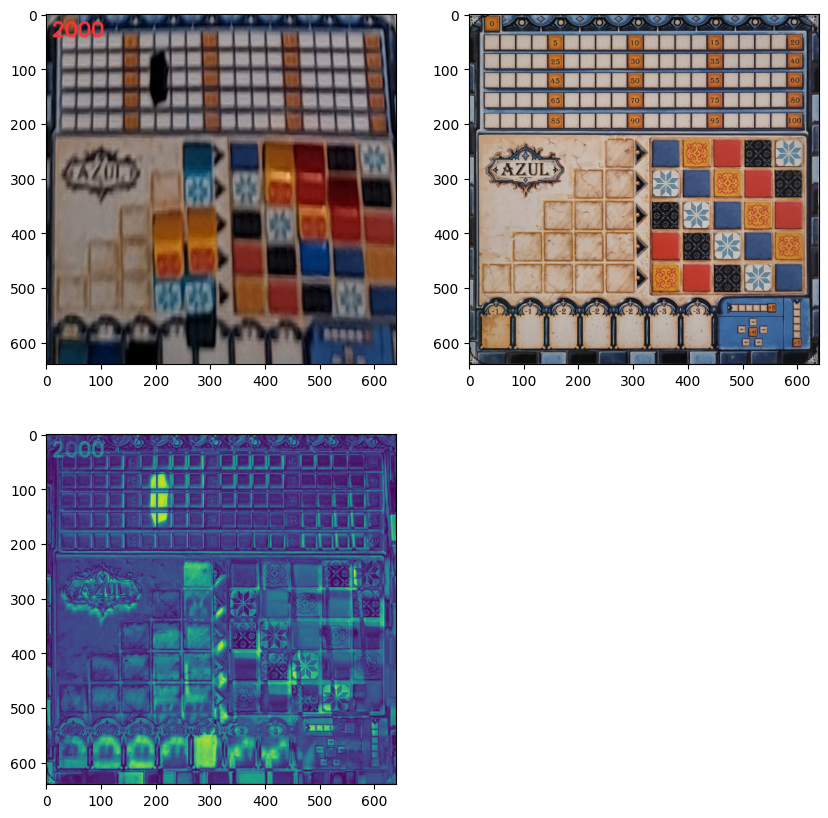

In [85]:
frame = imgBoards[3].copy()
# frame = cv2.blur(frame, [ksz, ksz])

diff = np.sum(np.abs(frame.astype(float) - template), axis=2)

plt.figure(figsize=(10,10))
plt.subplot(221), plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB));
plt.subplot(222), plt.imshow(cv2.cvtColor(template, cv2.COLOR_BGR2RGB));
plt.subplot(223), plt.imshow(diff);

In [129]:
img = cv2.imread('../Pictures/azul/raw/20230831_184436.jpg')  # hard
plot = False 

imgClean = img.copy()
masks = vision.segment(img, plot)
maskMerge = np.sum(np.uint8(masks), axis=0).astype(np.uint8)

h1, w1 = masks[0].shape
hf, wf, _ = img.shape
BRD, FSZ = 80, 800
dst = np.float32([[BRD, BRD], [FSZ-BRD, BRD],
                    [FSZ-BRD, FSZ-BRD], [BRD, FSZ-BRD]])

BRD2, FSZ2 = 30, 640
sz = FSZ2 / 640
dst2 = np.float32([[BRD2, BRD2], [FSZ2-BRD2, BRD2],
                    [FSZ2-BRD2, FSZ2-BRD2], [BRD2, FSZ2-BRD2]])

MIN_MATCH_VAL = 1500
BORDER_COLOR = (81, 56, 40)

i, data = 0, masks[3]

mask = np.uint8(data)
src = vision.corners_from_mask(mask)
matrix = cv2.getPerspectiveTransform(
    np.float32(src * [wf/w1, hf/h1]), dst)
frame = cv2.warpPerspective(
    imgClean, matrix, (FSZ, FSZ), borderMode=cv2.BORDER_REPLICATE)


0: 480x640 4 boards, 67.8ms
Speed: 2.4ms preprocess, 67.8ms inference, 5.3ms postprocess per image at shape (1, 3, 640, 640)


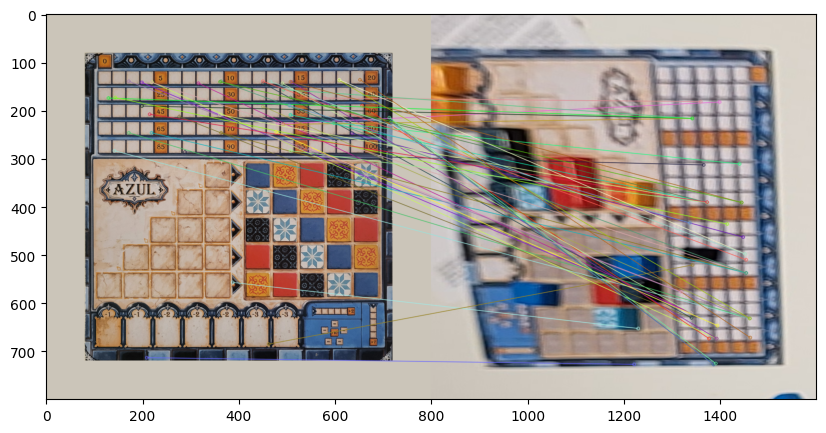

In [130]:
border = BRD 

features1 = vision.FeatureExtraction(frame)
matches = vision.feature_matching(vision._features0, features1)

H, _ = cv2.findHomography(features1.matched_pts, vision._features0.matched_pts, cv2.RANSAC, 5.0)
warped = cv2.warpPerspective(frame, H, (w, h))

# plt.imshow(frame);
matched_image = cv2.drawMatches(vision.template, vision._features0.kps, frame, features1.kps, matches, None, flags=2)

plt.figure(figsize=(10,5))
plt.imshow(cv2.cvtColor(matched_image, cv2.COLOR_BGR2RGB));
# plt.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB));

# cv2.findHomography(
#         features1.matched_pts, vision._features0.matched_pts, cv2.RANSAC, 5.0)[0]

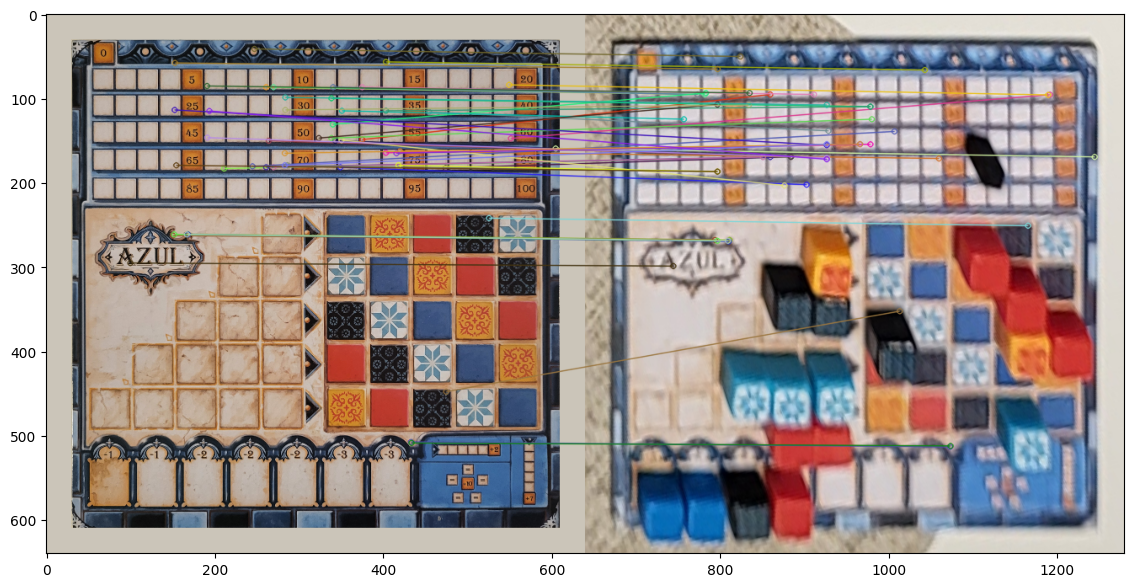

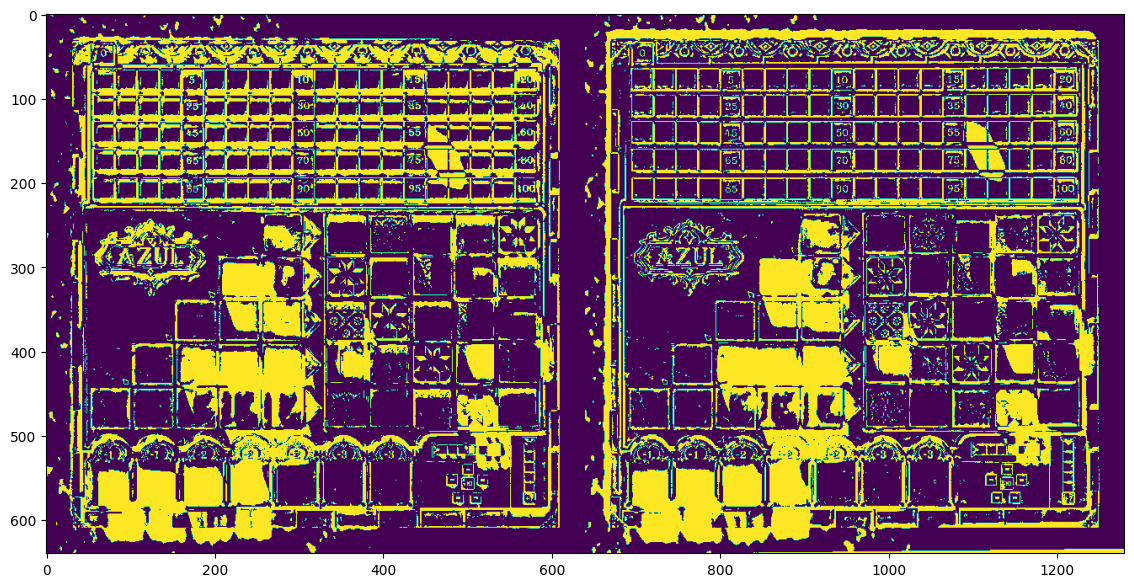

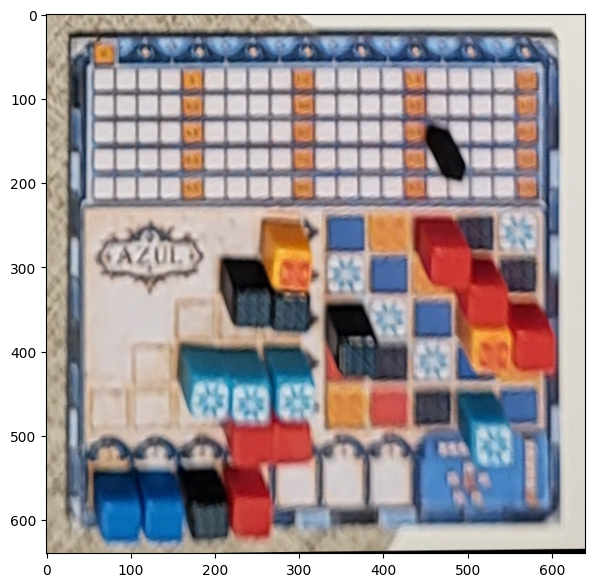

In [102]:
from warnings import warn 

orb = cv2.ORB_create(
    nfeatures=1000,
    scaleFactor=1.2,
    edgeThreshold=5,
    patchSize=31,
    scoreType=cv2.ORB_HARRIS_SCORE)
index_params = dict(
    algorithm = 6, # FLANN_INDEX_LSH
    table_number = 6,
    key_size = 10,
    multi_probe_level = 2)

# orb = cv2.SIFT_create(
#     nfeatures=500,
#     contrastThreshold=0.04,
#     edgeThreshold=10,
#     sigma=5)
# index_params = dict(algorithm = 1, trees = 5)  # for SIFT

class FeatureExtraction:
    def __init__(self, img):
        h, w, c = img.shape
        self.img = img.copy()
        # self.img = cv2.blur(self.img, [9, 9])
        # self.img = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
        # self.img[:, :, 0] = cv2.equalizeHist(self.img[:, :, 0])
        # self.img = cv2.cvtColor(self.img, cv2.COLOR_YCrCb2BGR)

        self.gray_img = cv2.cvtColor(self.img, cv2.COLOR_BGR2GRAY)
        # self.gray_img = cv2.cvtColor(self.img, cv2.COLOR_BGR2RGB)
        self.kps, self.des = orb.detectAndCompute( \
            self.gray_img, None)
        
        # add position to descriptor
        # pts = np.uint8([(kp.pt[0]*255/w, kp.pt[1]*255/h) for kp in self.kps])
        # self.des = np.hstack([self.des, pts, pts])
        # self.des = pts

        # self.img_kps = cv2.drawKeypoints( \
        #     self.img, self.kps, 0, \
        #     flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
        self.matched_pts = []

LOWES_RATIO = 0.7
MIN_MATCHES = 15

search_params = dict(checks=50)
flann = cv2.FlannBasedMatcher(
    index_params,
    search_params)

def feature_matching(features0, features1):
    matches = [] # good matches as per Lowe's ratio test
    if(features0.des is not None and len(features0.des) > 2):
        all_matches = flann.knnMatch( \
            features0.des, features1.des, k=2)
        try:
            for m,n in all_matches:
                if m.distance < LOWES_RATIO * n.distance:
                    matches.append(m)
        except ValueError:
            pass
        if(len(matches) > MIN_MATCHES):    
            features0.matched_pts = np.float32([features0.kps[m.queryIdx].pt for m in matches ]).reshape(-1,1,2)
            features1.matched_pts = np.float32( \
                [ features1.kps[m.trainIdx].pt for m in matches ] \
                ).reshape(-1,1,2)
        else:
            warn(f"Not enough matches: {len(matches)} < {MIN_MATCHES}")
    else:
        warn(f"I don't even know")
    return matches

features0 = FeatureExtraction(template)
features1 = FeatureExtraction(frame)
matches = feature_matching(features0, features1)

matched_image = cv2.drawMatches(features0.img, features0.kps, features1.img, features1.kps, matches, None, flags=2)

plt.figure(figsize=(15,7))
plt.imshow(cv2.cvtColor(matched_image, cv2.COLOR_BGR2RGB));

H, _ = cv2.findHomography(features1.matched_pts, features0.matched_pts, cv2.RANSAC, 5.0)
warped = cv2.warpPerspective(frame, H, (w, h))

diff1 = np.sum(np.abs(frame.astype(float) - template), axis=2)
diff2 = np.sum(np.abs(warped.astype(float) - template), axis=2)
diff1 = (diff1 - 0) / (diff1.std()) > 1.5
diff2 = (diff2 - 0) / (diff2.std()) > 1.5

plt.figure(figsize=(14,7))
plt.imshow(np.hstack([diff1, diff2]));

plt.figure(figsize=(7,7))
plt.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB));

In [109]:
# Hinv, _ = cv2.findHomography(features0.matched_pts, features1.matched_pts, cv2.RANSAC, 5.0)
corners = np.array([
    [brd, brd, 1],
    [w-brd, brd, 1],
    [w-brd, h-brd, 1],
    [brd, h-brd, 1]]) @ Hinv.T

array([[      34.96,        38.2,           1],
       [     606.27,      40.991,     0.99405],
       [     608.03,      615.57,      1.0006],
       [     36.723,      612.78,      1.0066]])

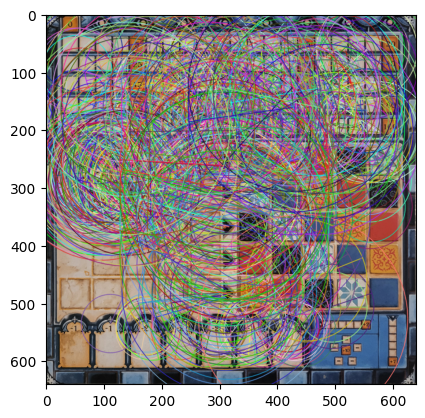

In [26]:
orb = cv2.ORB_create(
    nfeatures=500,
    scaleFactor=1.2,
    edgeThreshold=31,
    patchSize=101,
    scoreType=cv2.ORB_HARRIS_SCORE)

class FeatureExtraction:
    def __init__(self, img):
        self.img = img.copy()

        self.gray_img = cv2.cvtColor(self.img, cv2.COLOR_BGR2RGB)
        self.kps, self.des = orb.detectAndCompute( \
            self.gray_img, None)
        self.img_kps = cv2.drawKeypoints( \
            self.img, self.kps, 0, \
            flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
        self.matched_pts = []

# bVal = (255,255,255)
# brd = 100
# matrix = np.float32([
#     [1, 0, brd],
#     [0, 1, brd]])
# features0 = FeatureExtraction(cv2.warpAffine(template, matrix, [w+2*brd, h+2*brd], borderValue=bVal))
features0 = FeatureExtraction(template)

plt.imshow(cv2.cvtColor(features0.img_kps, cv2.COLOR_BGR2RGB));

In [99]:
%%timeit 
# total before 17.4 ms
# total after (32 + 4 features) 18.3 ms

# features0 = FeatureExtraction(template)
features1 = FeatureExtraction(frame)  # 9.4 ms
matches = feature_matching(features0, features1)  # 8.2 ms
H, _ = cv2.findHomography(features1.matched_pts, features0.matched_pts, cv2.RANSAC, 5.0)

44.7 ms ± 2.93 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)



0: 480x640 4 boards, 269.4ms
Speed: 12.8ms preprocess, 269.4ms inference, 3.9ms postprocess per image at shape (1, 3, 640, 640)


'/home/garamizo/Pictures/azul/raw/20230831_184730.jpg'

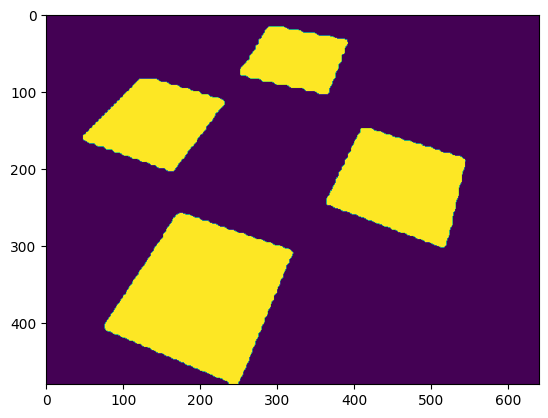

In [320]:
imgBoards, maskMerge = vision.get_boards(img)
h, w, c = imgBoards[0].shape
numBoards = len(imgBoard)

# imgBoards = imgBoards + [np.zeros([h,w,c], np.uint8)] * (4 - numBoards)
# tiles = np.reshape(imgBoards, [2, 2, h, w, c])
# tiles = tiles.swapaxes(1, 2).reshape(h*2, w*2, c)

# h0, w0, c0 = img.shape 
# frame = np.hstack([cv2.resize(img, [int(w0 * 2*h/h0), 2*h]), tiles])

# plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB));
plt.imshow(maskMerge)
file

In [310]:
cv2.resize(img, [int(w0 * 2*h/h0), 2*h]).shape, tiles.shape

((1280, 1706, 3), (1280, 1280, 3))

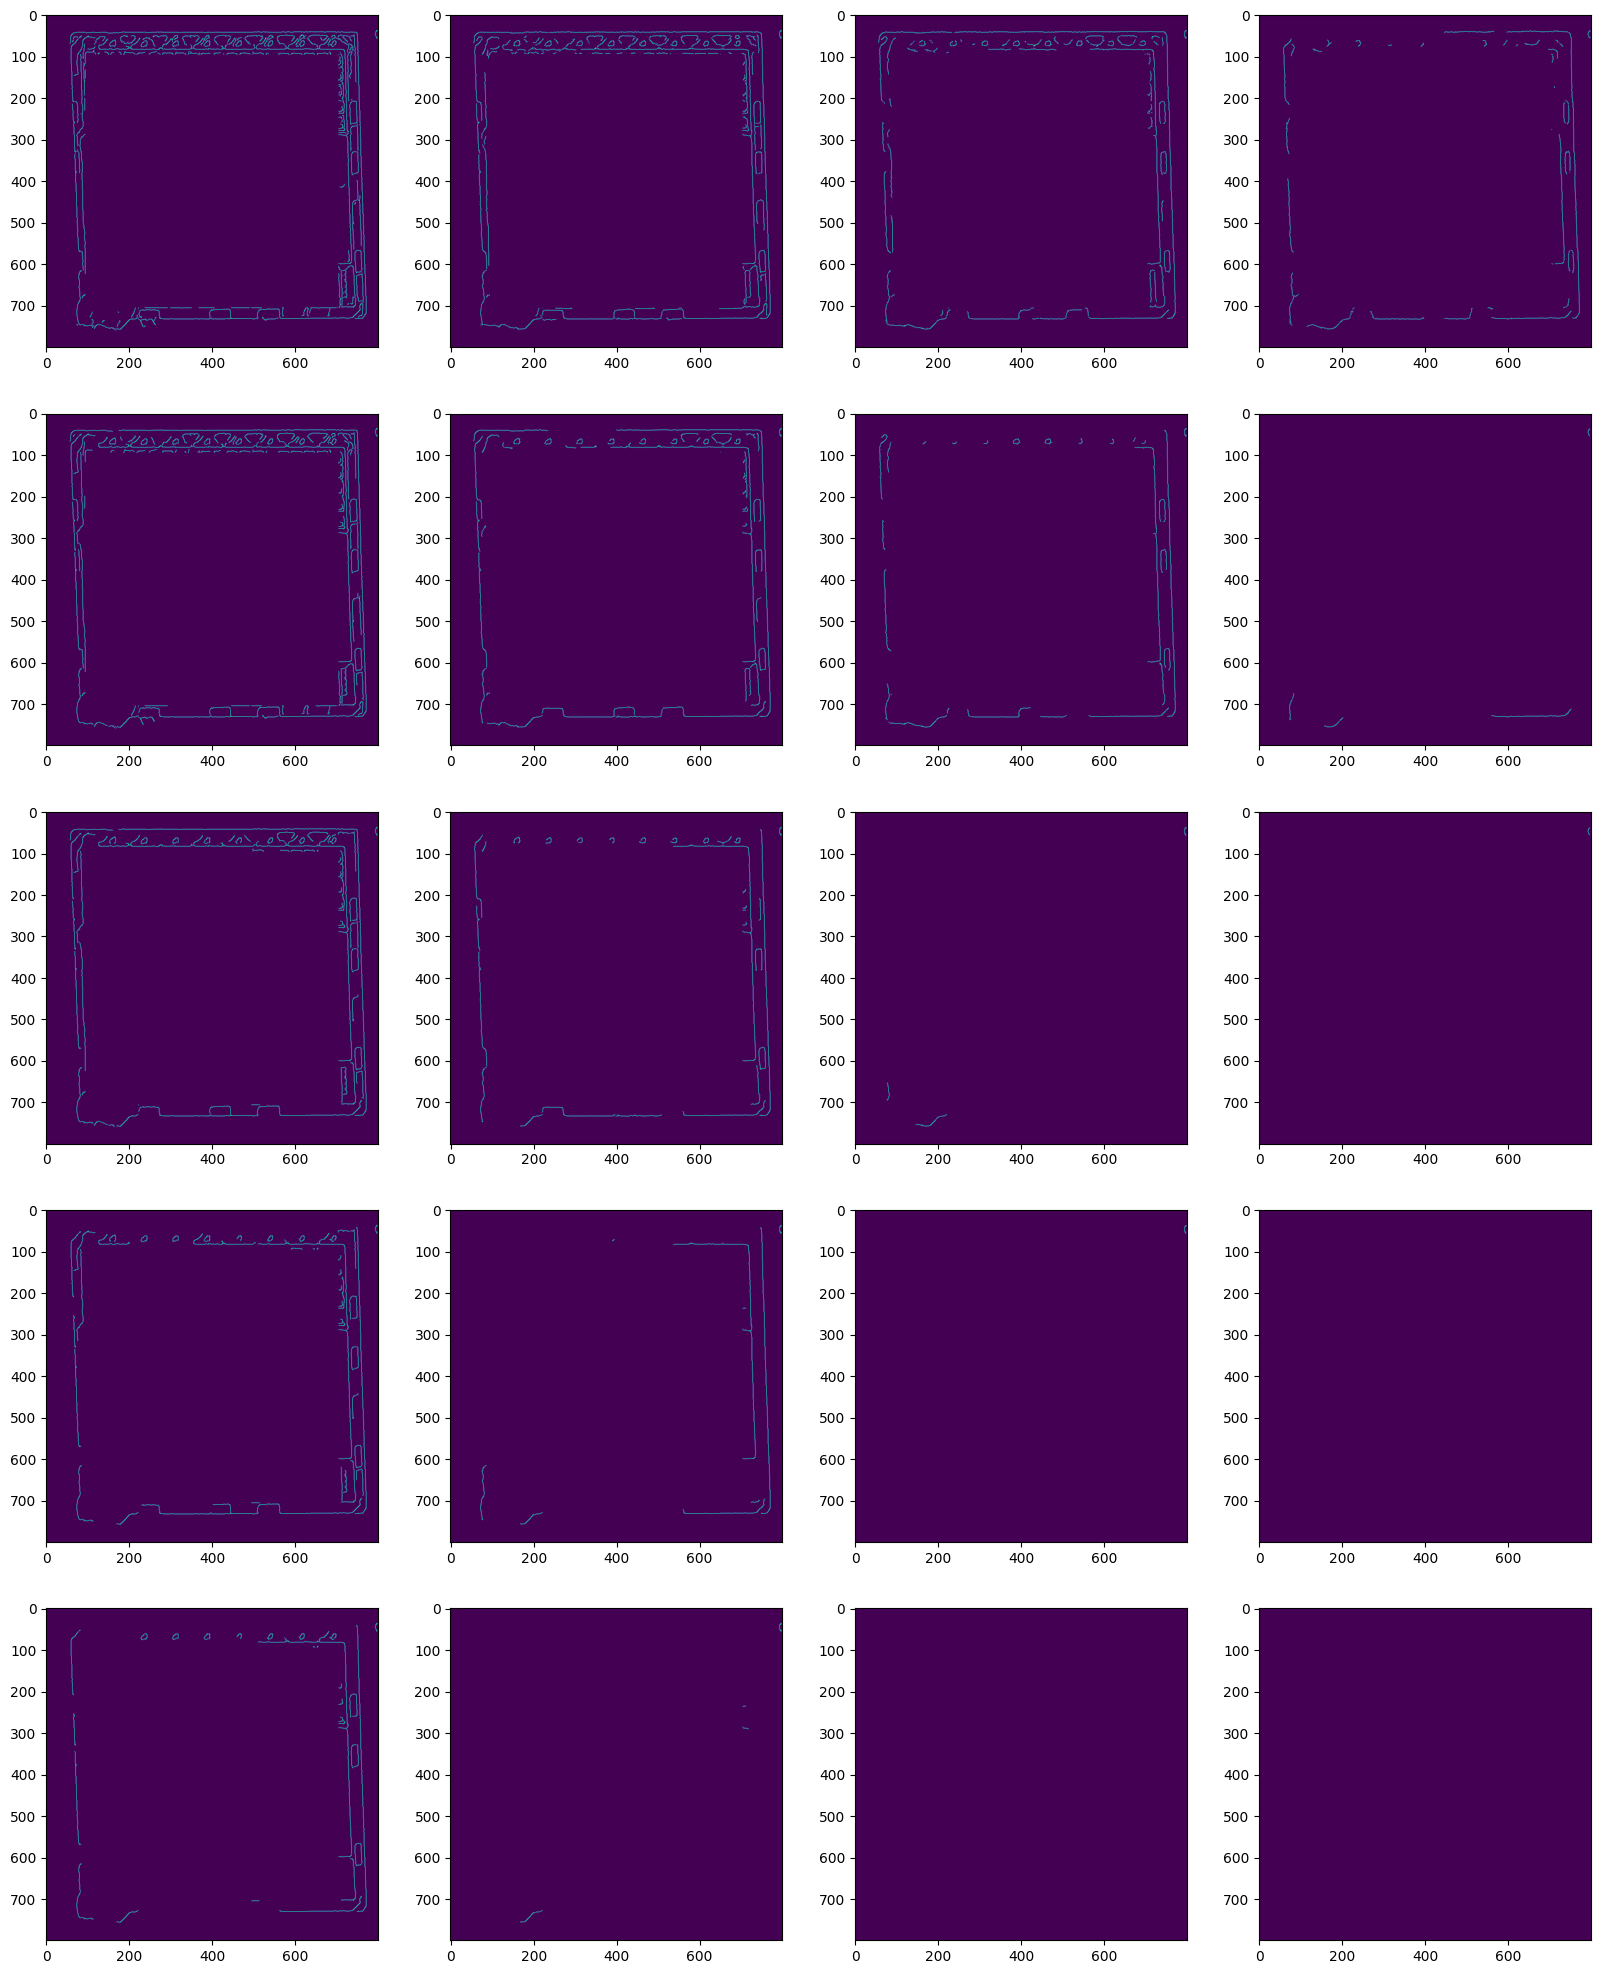

In [267]:
src = imgBoard[-1].copy()
src[100:-100,100:-100,:] = 0

mask = np.ones(src.shape[:2], np.uint8)
mask[95:-95,95:-95] = 0

# thresh1=50, kernel=9 (t2=t1*3, 800x800 px)
thresh1 = np.arange(30, 80, 10)  # threshold1 = threshold2/3
thresh2 = np.arange(5, 13, 2)  # blur kerner size

plt.figure(figsize=(20,20*len(thresh1)/len(thresh2)))
for i, t1 in enumerate(thresh1):
    for j, t2 in enumerate(thresh2):
        dst = cv2.blur(src, (t2,t2))
        dst = cv2.blur(dst, (t2,t2))
        dst = cv2.Canny(dst, threshold1=t1, threshold2=t1*3, edges=None, apertureSize=3)
        dst = dst * mask
        plt.subplot(len(thresh1), len(thresh2), i*len(thresh2) + j + 1)
        plt.imshow(dst);

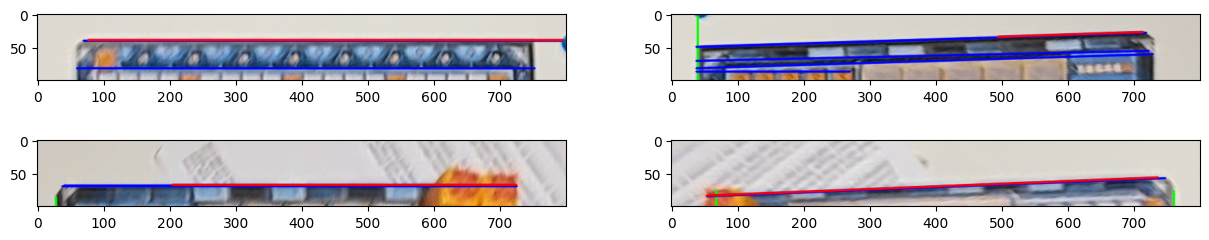

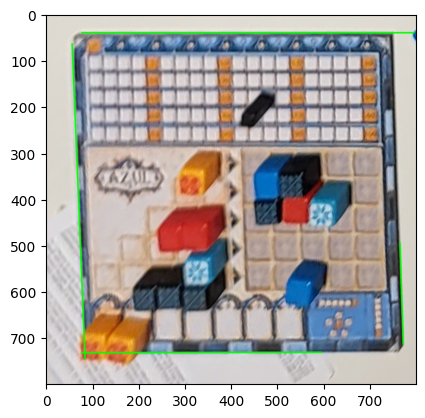

In [268]:
/home/garamizo/Pictures/azul/raw/20230831_184730.jpg
frame = imgBoard[-1].copy()

t1, ksz, asz = 40, 7, 3
brd = 100
minVotes = 75
stepRho = 0.5
stepTheta = 0.25 * np.pi/180
h, w = frame.shape[:2]

def get_best_line(lines):
    rhoTol = 3 
    thetaTol = 1*np.pi/180

    success = False 
    inlier = np.ones(lines.shape[0]) > 0
    line = np.median(lines[inlier,0,:], 0)
    for tries in range(10):
        if (np.all(np.abs(lines[inlier,0,0] - line[0]) < rhoTol) and 
            np.all(np.abs(lines[inlier,0,1] - line[1])) < thetaTol):
            success = True 
            break
        line = np.median(lines[inlier,0,:], 0)
        inlier = (np.abs(lines[:,0,0] - line[0]) < rhoTol) & (np.abs(lines[:,0,1] - line[1]) < thetaTol)
    return line, success, tries 

coefs = []
plt.figure(figsize=(15,3))
for j in range(4):
    matrix = cv2.getRotationMatrix2D([w//2, h//2], j*90, scale=1)
    src = cv2.warpAffine(frame, matrix, [w, brd])

    dst = cv2.blur(src, (ksz,ksz))
    dst = cv2.blur(dst, (ksz,ksz))
    dst = cv2.Canny(dst, threshold1=t1, threshold2=t1*3, edges=None, apertureSize=asz)
    # lines = cv2.HoughLines(dst, rho=stepRho, theta=stepTheta, threshold=minVotes, min_theta=85*np.pi/180, max_theta=95*np.pi/180)  # vlines
    lines = cv2.HoughLinesP(dst, rho=stepRho, theta=stepTheta, threshold=minVotes, minLineLength=100, maxLineGap=200)

    if lines is not None:
        # line = get_best_line(lines)[0]
        # line = lines[0,0,:]  # most votes
        # y-min from best 5 (out-most from board)
        y = lines[:5,0,1] + lines[:5,0,3]
        line = lines[np.argmin(y),0,:]
        lines = np.vstack([lines, line[np.newaxis,np.newaxis,:]])
        # print(lines)

        for i in range(len(lines)):
            # rho = lines[i][0][0]
            # theta = lines[i][0][1]
            # a = np.cos(theta)
            # b = np.sin(theta)
            # x0 = a * rho
            # y0 = b * rho
            # pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
            # pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
            # cv2.line(src, pt1, pt2, (0,0,255) if i==len(lines)-1 else (255,0,0), 2, cv2.LINE_AA)

            l = lines[i][0]
            cv2.line(src, (l[0], l[1]), (l[2], l[3]), (0,0,255) if i==len(lines)-1 else (255,0,0), 2, cv2.LINE_AA)

        p1, p2 = line[:2], line[2:]
        matrixInv = cv2.invertAffineTransform(matrix)
        P1 = np.int32(matrixInv @ np.r_[p1, 1])
        P2 = np.int32(matrixInv @ np.r_[p2, 1])
        s0 = (P1 + P2) / 2
        v = (P2 - P1) / np.sqrt(((P2 - P1)**2).sum())
        coefs.append([s0, v])
        cv2.line(frame, P1, P2, (0,255,0), 2, cv2.LINE_AA)
        
        plt.subplot(2,2,j+1)
        plt.imshow(cv2.cvtColor(src, cv2.COLOR_BGR2RGB));

plt.figure()
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB));

In [270]:
frame = imgBoard[-1].copy()

vision.corner_from_closeup(frame)

array([[     55.015,          40],
       [     750.68,          40],
       [     772.56,      730.66],
       [     83.425,      731.99]])

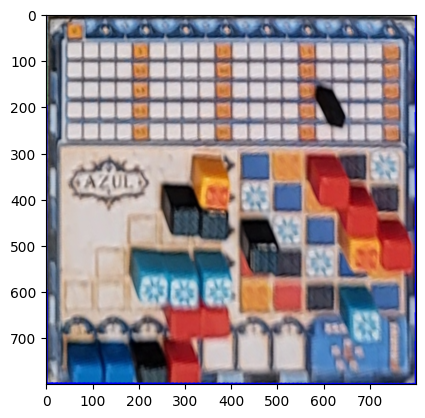

In [262]:
def signed_area(u, v):
    return u[0] * v[1] - u[1] * v[0]

def get_corners(coefs, numCorners=4):
    # calc intersection of edges, filtering out non intersecting edges
    c0 = np.mean([s0 for s0, v in coefs], 0)
    corners = np.ones([numCorners, 2]) * np.Inf
    idxPrev = [0] * numCorners
    for i, (si, vi) in enumerate(coefs):
        for j in range(i+1, numCorners):
            sj, vj = coefs[j]

            ts = np.linalg.solve(np.c_[vi, -vj], sj - si)
            pt = si + ts[0] * vi

            # color = i*numCorners + j + 2
            # pts = np.c_[si, pt, sj].T
            # cv2.polylines(mask, [np.int32(pts)], False, color, thickness=2)
            # cv2.circle(mask, np.int32(pt), 10, color, thickness=3)

            idx, idxN = (i, j) if signed_area(si - c0, sj - c0) < 0 else (j, i)
            if np.sum((pt - c0)**2) < np.sum((corners[idx, :] - c0)**2):
                corners[idx, :] = pt
                idxPrev[idx] = idxN
                if coefs[idx][1] @ (coefs[idx][0] - pt) < 0:
                    coefs[idx][1] *= -1

    # sort corners in +z order
    corners_ = np.zeros([numCorners, 2])
    coefs_ = np.zeros([numCorners, 4])
    idx = idxPrev[-1]
    for i in range(numCorners-1, -1, -1):
        corners_[i] = corners[idx]
        coefs_[i] = np.r_[coefs[idx][0], coefs[idx][1]]
        idx = idxPrev[idx]
        # cv2.polylines(mask, [np.int32(pts)], False, 3, thickness=2)
        # cv2.putText(mask, f"{j}", np.int32(pt), 1, fontScale=2, color=5, thickness=2)

    # make first index the top-most
    idx = np.argmin(corners_[:, 1])  # top-most
    corners_ = np.roll(corners_, -idx, axis=0)
    coefs_ = np.roll(coefs_, -idx, axis=0)

    # for j in range(numCorners):
    #     sj, vj = coefs_[j][:2], coefs_[j][2:]
    #     pt = corners_[j]
    #     pts = np.c_[pt, pt + vj * 150].T
    #     cv2.polylines(mask, [np.int32(pts)], False, 2, thickness=1)
    #     cv2.putText(mask, f"{j}", np.int32(pt), 1, fontScale=2, color=3, thickness=2)

    return corners_  # , (idxNext, xy, labels, np.c_[dxy, seqSin, seqCos])

src = np.float32(get_corners(np.array(coefs)))
# cv2.polylines(frame, [src.astype(np.int32)], True, (255, 0, 0), 3)

BRD, FSZ = 0, 800
dst = np.float32([[BRD, BRD], [FSZ-BRD, BRD], [FSZ-BRD, FSZ-BRD], [BRD, FSZ-BRD]])

matrix = cv2.getPerspectiveTransform(src, dst)
img = cv2.warpPerspective(frame, matrix, (FSZ, FSZ))

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB));

In [260]:
src

array([[     43.982,      34.822],
       [     740.49,       43.68],
       [     727.36,      799.05],
       [     45.076,      710.98]])

array([100, 730], dtype=int32)

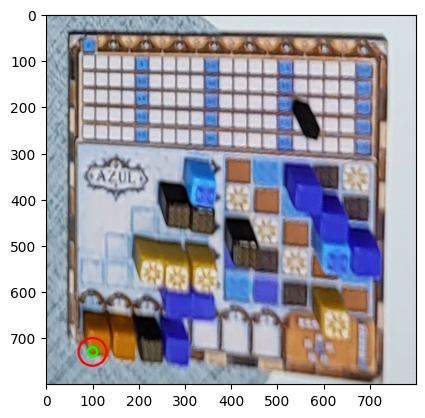

In [240]:
# p1, p2 = lines[0,0,:2], lines[0,0,2:]
# matrixInv = cv2.invertAffineTransform(matrix)
# matrixInv @ np.r_[p1, 1]

img1 = frame.copy()
P1 = np.int32([100, 730])
cv2.circle(img1, P1, 30, (255,0,0), 3)

matrix = cv2.getRotationMatrix2D([w//2, h//2], 2*90, scale=1)
src = cv2.warpAffine(img1, matrix, [w, brd])

p1 = np.int32(matrix @ np.r_[P1, 1])
cv2.circle(src, p1, 20, (0,0,255), 3)

matrixInv = cv2.invertAffineTransform(matrix)
PP1 = np.int32(matrixInv @ np.r_[p1, 1])
cv2.circle(img1, PP1, 10, (0,255,0), 3)

plt.imshow(img1);
PP1

In [176]:
frame = imgBoard[-2].copy()

t1, ksz, asz = 40, 9, 3
brd = 100
minVotes = 100
stepRho = 0.5
stepTheta = 0.25 * np.pi/180
h, w = frame.shape[:2]

def get_best_line(lines):
    rhoTol = 3 
    thetaTol = 1*np.pi/180

    success = False 
    inlier = np.ones(lines.shape[0]) > 0
    line = np.median(lines[inlier,0,:], 0)
    for tries in range(10):
        if (np.all(np.abs(lines[inlier,0,0] - line[0]) < rhoTol) and 
            np.all(np.abs(lines[inlier,0,1] - line[1])) < thetaTol):
            success = True 
            break
        line = np.median(lines[inlier,0,:], 0)
        inlier = (np.abs(lines[:,0,0] - line[0]) < rhoTol) & (np.abs(lines[:,0,1] - line[1]) < thetaTol)
    return line, success, tries 

plt.figure(figsize=(15,3))
for j in range(4):
    matrix = cv2.getRotationMatrix2D([w//2, h//2], j*90, scale=1)
    src = cv2.warpAffine(frame, matrix, [w, brd])

    dst = cv2.blur(src, (ksz,ksz))
    dst = cv2.blur(dst, (ksz,ksz))
    dst = cv2.Canny(dst, threshold1=t1, threshold2=t1*3, edges=None, apertureSize=asz)
    # lines = cv2.HoughLines(dst, rho=stepRho, theta=stepTheta, threshold=minVotes, min_theta=85*np.pi/180, max_theta=95*np.pi/180)  # vlines
    lines = cv2.HoughLinesP(dst, rho=stepRho, theta=stepTheta, threshold=minVotes, minLineLength=300, maxLineGap=200)

    if lines is not None:
        # line = get_best_line(lines)[0]
        line = lines[0,0,:]
        lines = np.vstack([lines, line[np.newaxis,np.newaxis,:]])

        for i in range(len(lines)):
            # rho = lines[i][0][0]
            # theta = lines[i][0][1]
            # a = np.cos(theta)
            # b = np.sin(theta)
            # x0 = a * rho
            # y0 = b * rho
            # pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
            # pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
            # cv2.line(src, pt1, pt2, (0,0,255) if i==len(lines)-1 else (255,0,0), 2, cv2.LINE_AA)

            l = lines[i][0]
            cv2.line(src, (l[0], l[1]), (l[2], l[3]), (0,0,255) if i==len(lines)-1 else (255,0,0), 2, cv2.LINE_AA)
        
        plt.subplot(2,2,j+1)
        plt.imshow(cv2.cvtColor(src, cv2.COLOR_BGR2RGB));

(3, 1, 4)

In [189]:
lines = np.array([0,1,4])
cv2.HoughLinesP(dst, rho=stepRho, theta=stepTheta, threshold=minVotes, minLineLength=300, maxLineGap=200, lines=lines)
lines.shape

error: OpenCV(4.8.0) :-1: error: (-5:Bad argument) in function 'HoughLinesP'
> Overload resolution failed:
>  - Layout of the output array lines is incompatible with cv::Mat
>  - Expected Ptr<cv::UMat> for argument 'lines'


In [90]:
import azul.vision as vision 

img = imgBoard[-1]

def get_score(img):
    scale = img.shape[0]/2500

    valueBest = np.Inf
    for row in range(vision.SHAPE_SCORE[0]):
        for col in range(vision.SHAPE_SCORE[1]):
            frame = crop(img, vision.RECT_SCORE, vision.SHAPE_SCORE, vision.SIZE_MARKER, row, col, scale)
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
            value = np.median(frame[:,:,2])
            if value < valueBest:
                idx = (row, col)
                valueBest = value
                # frameBest = cv2.cvtColor(frame, cv2.COLOR_HSV2BGR)
    return idx[1] + (idx[0] - 1) * vision.SHAPE_SCORE[1] + 1#, idx, frameBest


def crop(img, rect, shape, size, row, col, scale):
    step = (rect[2] // (shape[1]-1), rect[3] // (shape[0]-1))
    rectij = (rect[0] + step[0] * col - size[0]//2, rect[1] + step[1] * row - size[1]//2, *size)
    rectij = [int(a * scale) for a in rectij]
    return img[rectij[1]:(rectij[1]+rectij[3]),rectij[0]:(rectij[0]+rectij[2]),:]

# frame = crop(img, vision.RECT_LINE, vision.SHAPE_LINE, vision.SIZE_TILE, 0, 4, img.shape[0]/2500)
# frame = crop(img, vision.RECT_GRID, vision.SHAPE_GRID, vision.SIZE_TILE, 0, 2, img.shape[0]/2500)
# frame = crop(img, vision.RECT_FLOOR, vision.SHAPE_FLOOR, vision.SIZE_TILE, 0, 0, img.shape[0]/2500)
frame = crop(img, vision.RECT_SCORE, vision.SHAPE_SCORE, vision.SIZE_MARKER, 2, 6, img.shape[0]/2500)

histB = cv2.calcHist([frame], [0], None, histSize=[4], ranges=(0,256))
# histB /= histB.sum()

rect = (400, 300, 200, 200)
score, idx, frameMarker = get_score(img)

plt.imshow(cv2.cvtColor(frameMarker, cv2.COLOR_BGR2RGB));
score, idx

TypeError: cannot unpack non-iterable int object

In [92]:
%%timeit
get_score(imgBoard[0])

4.17 ms ± 299 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [78]:
# 120, 80, 5
# frame = crop(img, vision.RECT_SCORE, vision.SHAPE_SCORE, vision.SIZE_MARKER, 2, 6, img.shape[0]/2500)
# 14, 196, 147
# frame = crop(img, vision.RECT_SCORE, vision.SHAPE_SCORE, vision.SIZE_MARKER, 0, 0, img.shape[0]/2500)
# 120, 11, 172
frame = crop(img, vision.RECT_SCORE, vision.SHAPE_SCORE, vision.SIZE_MARKER, 1, 0, img.shape[0]/2500)

frame = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
np.median(frame[:,:,0]), np.median(frame[:,:,1]), np.median(frame[:,:,2])

(120.0, 11.0, 172.0)

## Tile Recognition
Assumptions:
- Expert mode
- Perspective transformation was not too extreme

Expert mode Algorithm:
- Crop to the tightest box
- Gaussian blur on img and template
- Get RGB of each tile-keypoint location
- In doubt, use game constraints of where tiles can be placed

Basic mode Algorithm:
- Crop to the tightest box
- Gaussian blur on img and template (or compare within tile box)
- Texture on img and template
- Get RGB or texture deviation each tile-keypoint location
- In doubt, use game constraints of where tiles can be placed

Preparation:
- Get keypoints with GIMP
- Calculate relationship between perspective matrix and the pixel offset on tile top plane